#### library

In [46]:
import os
from typing import List, Dict
from tqdm import tqdm
import numpy as np

# visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# warning
import warnings
warnings.filterwarnings('ignore')

# sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.preprocessing import add_dummy_feature
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

# statsmodel
import statsmodels.api as sm
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tsa.stattools import adfuller, kpss
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.multivariate.manova import MANOVA


# model
import lightgbm as lgb
import optuna
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch.optim as optim


print(torch.__version__)

2.4.1+cu121


#### data load

In [13]:
# 파일 호출
data_path: str = "../../../data"
train_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "train.csv")).assign(_type="train") # train 에는 _type = train 
test_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")).assign(_type="test") # test 에는 _type = test
submission_df: pd.DataFrame = pd.read_csv(os.path.join(data_path, "test.csv")) # ID, target 열만 가진 데이터 미리 호출
df: pd.DataFrame = pd.concat([train_df, test_df], axis=0)

In [14]:
# HOURLY_ 로 시작하는 .csv 파일 이름을 file_names 에 할딩
file_names: List[str] = [
    f for f in os.listdir(data_path) if f.startswith("HOURLY_") and f.endswith(".csv")
]

# 파일명 : 데이터프레임으로 딕셔너리 형태로 저장
file_dict: Dict[str, pd.DataFrame] = {
    f.replace(".csv", ""): pd.read_csv(os.path.join(data_path, f)) for f in file_names
}

for _file_name, _df in tqdm(file_dict.items()):
    # 열 이름 중복 방지를 위해 {_file_name.lower()}_{col.lower()}로 변경, datetime 열을 ID로 변경
    _rename_rule = {
        col: f"{_file_name.lower()}_{col.lower()}" if col != "datetime" else "ID"
        for col in _df.columns
    }
    _df = _df.rename(_rename_rule, axis=1)
    df = df.merge(_df, on="ID", how="left")


100%|██████████| 107/107 [00:02<00:00, 37.79it/s]


#### baseline feature engineering

In [15]:
eda_df = df.loc[df["_type"] == "train"]

In [5]:
# 모델에 사용할 컬럼, 컬럼의 rename rule을 미리 할당함
cols_dict: Dict[str, str] = {
    "ID": "ID",
    "target": "target",
    "_type": "_type",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_gap": "coinbase_premium_gap",
    "hourly_market-data_coinbase-premium-index_coinbase_premium_index": "coinbase_premium_index",
    "hourly_market-data_funding-rates_all_exchange_funding_rates": "funding_rates",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations": "long_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_long_liquidations_usd": "long_liquidations_usd",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations": "short_liquidations",
    "hourly_market-data_liquidations_all_exchange_all_symbol_short_liquidations_usd": "short_liquidations_usd",
    "hourly_market-data_open-interest_all_exchange_all_symbol_open_interest": "open_interest",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_ratio": "buy_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_sell_ratio": "buy_sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_buy_volume": "buy_volume",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_ratio": "sell_ratio",
    "hourly_market-data_taker-buy-sell-stats_all_exchange_taker_sell_volume": "sell_volume",
    "hourly_network-data_addresses-count_addresses_count_active": "active_count",
    "hourly_network-data_addresses-count_addresses_count_receiver": "receiver_count",
    "hourly_network-data_addresses-count_addresses_count_sender": "sender_count",
}
df = df[cols_dict.keys()].rename(cols_dict, axis=1)
df.shape

(11552, 19)

In [6]:
# eda 에서 파악한 차이와 차이의 음수, 양수 여부를 새로운 피쳐로 생성
df = df.assign(
    liquidation_diff=df["long_liquidations"] - df["short_liquidations"],
    liquidation_usd_diff=df["long_liquidations_usd"] - df["short_liquidations_usd"],
    volume_diff=df["buy_volume"] - df["sell_volume"],
    liquidation_diffg=np.sign(df["long_liquidations"] - df["short_liquidations"]),
    liquidation_usd_diffg=np.sign(df["long_liquidations_usd"] - df["short_liquidations_usd"]),
    volume_diffg=np.sign(df["buy_volume"] - df["sell_volume"]),
    buy_sell_volume_ratio=df["buy_volume"] / (df["sell_volume"] + 1),
)
# category, continuous 열을 따로 할당해둠
category_cols: List[str] = ["liquidation_diffg", "liquidation_usd_diffg", "volume_diffg"]
conti_cols: List[str] = [_ for _ in cols_dict.values() if _ not in ["ID", "target", "_type"]] + [
    "buy_sell_volume_ratio",
    "liquidation_diff",
    "liquidation_usd_diff",
    "volume_diff",
]

In [7]:
def shift_feature(
    df: pd.DataFrame,
    conti_cols: List[str],
    intervals: List[int],
) -> List[pd.Series]:
    """
    연속형 변수의 shift feature 생성
    Args:
        df (pd.DataFrame)
        conti_cols (List[str]): continuous colnames
        intervals (List[int]): shifted intervals
    Return:
        List[pd.Series]
    """
    df_shift_dict = [
        df[conti_col].shift(interval).rename(f"{conti_col}_{interval}")
        for conti_col in conti_cols
        for interval in intervals
    ]
    return df_shift_dict

# 최대 24시간의 shift 피쳐를 계산
shift_list = shift_feature(
    df=df, conti_cols=conti_cols, intervals=[_ for _ in range(1, 24)]
)

In [8]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)
df.head(3)

,ID,target,_type,coinbase_premium_gap,coinbase_premium_index,funding_rates,long_liquidations,long_liquidations_usd,short_liquidations,short_liquidations_usd,...,volume_diff_14,volume_diff_15,volume_diff_16,volume_diff_17,volume_diff_18,volume_diff_19,volume_diff_20,volume_diff_21,volume_diff_22,volume_diff_23
0,2023-01-01 00:00:00,2.0,train,-9.86,-0.059650,0.005049,0.012,197.5161,0.000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2023-01-01 01:00:00,1.0,train,-8.78,-0.053047,0.005049,0.000,0.0000,0.712,11833.56104,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2023-01-01 02:00:00,1.0,train,-9.59,-0.057952,0.005049,0.000,0.0000,0.000,0.00000,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [10]:
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = df.isnull().sum()
missing_percentage = (missing_values / len(df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)
missing_values

ID                           0
target                    2792
_type                        0
coinbase_premium_gap         6
coinbase_premium_index       6
                          ... 
volume_diff_19              31
volume_diff_20              31
volume_diff_21              31
volume_diff_22              31
volume_diff_23              31
Length: 486, dtype: int64

In [ ]:
# concat 하여 df 에 할당
df = pd.concat([df, pd.concat(shift_list, axis=1)], axis=1)

# 타겟 변수를 제외한 변수를 forwardfill, -999로 결측치 대체
_target = df["target"]
df = df.ffill().fillna(-999).assign(target = _target)

# _type에 따라 train, test 분리
train_df = df.loc[df["_type"]=="train"].drop(columns=["_type"])
test_df = df.loc[df["_type"]=="test"].drop(columns=["_type"])

* 애초에 df에서 list로 할당된 변수들만 사용했음
* 때문에 해당 값들은 결측치가 거의 없음
* 종가에 대한 데이터에 관련하여 변수추가를 진행함(진경이 데이터엔)
* 종가의 거래량과 관련하여 변수추가도 고려해볼 필요가 있음

#### new engineering

1. elasticnet을 통한 변수 추출

In [21]:
# missing value check

train_df = eda_df.copy()
# 각 열에서 누락된 값의 수 & 백분율 계산
missing_values = train_df.isnull().sum()
missing_percentage = (missing_values / len(train_df)) * 100

# 누락된 값 비율을 기준으로 열 정렬
sorted_missing_percentage = missing_percentage.sort_values(ascending=False)

# missing_value의 비율이 100%가 아닌 column만 추출
non_missing_columns = sorted_missing_percentage[sorted_missing_percentage != 100.0].index.tolist()
non_missing_columns.remove('ID')
non_missing_columns.remove('target')
non_missing_columns.remove('_type')

new_data = train_df[['ID','target', '_type'] + non_missing_columns]

In [22]:
# 이동평균으로 결측치 대체
new_df_stab = new_data[non_missing_columns]

# train
window_size = 3
new_df_stab = new_df_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_df_stab = new_df_stab.fillna(method='ffill').fillna(method='bfill')


# 결측치 처리한 new_df 정의
new_train_df = pd.concat([new_data[['ID','target','_type']], new_df_stab], axis=1)
new_train_df.head(3)

,ID,target,_type,hourly_market-data_open-interest_binance_btc_busd_open_interest,hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd,hourly_market-data_liquidations_binance_btc_busd_long_liquidations,hourly_market-data_liquidations_binance_btc_busd_short_liquidations,hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd,hourly_market-data_funding-rates_bybit_funding_rates,hourly_market-data_taker-buy-sell-stats_bybit_taker_buy_volume,...,hourly_market-data_liquidations_binance_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_binance_all_symbol_short_liquidations_usd,hourly_market-data_open-interest_htx_global_btc_usd_open_interest,hourly_network-data_addresses-count_addresses_count_receiver,hourly_network-data_fees_fees_total,hourly_network-data_fees_fees_total_usd,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations,hourly_market-data_liquidations_htx_global_all_symbol_long_liquidations_usd,hourly_market-data_liquidations_htx_global_all_symbol_short_liquidations_usd
0,2023-01-01 00:00:00,2.0,train,3.180371e+08,0.0,0.0,0.0,0.0,0.01,2015805.0,...,197.5161,0.00000,3.412540e+07,37752,0.561037,9271.503609,0.0,0.0,0.0,0.0
1,2023-01-01 01:00:00,1.0,train,3.183281e+08,0.0,0.0,0.0,0.0,0.01,4032601.0,...,0.0000,11833.56104,3.456750e+07,20534,0.256248,4237.095391,0.0,0.0,0.0,0.0
2,2023-01-01 02:00:00,1.0,train,3.179729e+08,0.0,0.0,0.0,0.0,0.01,857595.0,...,0.0000,0.00000,3.452090e+07,19369,0.312978,5176.614029,0.0,0.0,0.0,0.0


In [30]:
# 데이터프레임에서 입력 데이터(X)와 타겟 변수(y)로 분리
X = new_train_df.drop(columns=['target','ID','_type'])  # 'target'은 예측하려는 클래스
y = new_train_df['target']

# 2. 학습 데이터와 테스트 데이터 분리
X_train, X_valid, y_train, y_valid = train_test_split(X, y, shuffle=False, test_size=0.2, random_state=42)

# 3. 데이터 스케일링 (ElasticNet은 데이터 스케일에 민감하기 때문에 필요)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_valid)

# 4. ElasticNet 모델 설정 및 학습
elastic_net = ElasticNet(alpha=1.0, l1_ratio=0.5, random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# 5. 학습된 모델을 사용해 중요 변수 추출
# ElasticNet은 불필요한 변수의 계수를 0으로 만드므로, 중요 변수를 확인할 수 있음
coefficients = elastic_net.coef_

# 6. 피처 중요도 출력 (가중치가 0이 아닌 변수만 선택)
feature_importance = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': coefficients
})

# 가중치가 0이 아닌 변수만 선택
important_features = feature_importance[feature_importance['Coefficient'] != 0]
important_features = important_features.sort_values(by='Coefficient', ascending=False)

print("Selected Important Features:")
print(important_features)

212

모든 column에 대해 유의미하지 않다고 결과가 나옴

2. test에서 missing 100%인 데이터 모두 예측

In [32]:
# nan or inf 데이터 여부 확인
for col in non_missing_columns:
    if (np.isnan(new_train_df[col]).any()) | (np.isinf(new_train_df[col]).any()):
        print(col)
        break

In [33]:
test_df = df.loc[df["_type"] == "test"]
new_test_df = test_df[['ID','target','_type'] + non_missing_columns]

new_test_stab = new_test_df[non_missing_columns]
# test
window_size = 3
new_test_stab = new_test_stab.apply(lambda col: col.fillna(col.rolling(window=window_size, min_periods=1).mean()))
new_test_stab = new_test_stab.fillna(method='ffill').fillna(method='bfill')

new_test_df = pd.concat([new_test_df[['ID','target','_type']], new_test_stab], axis=1)

In [39]:
# 결측치 비율을 계산
missing_percentage = new_test_df.isnull().mean() * 100

# 결측치 비율이 100%인 컬럼 이름만 출력
columns_with_all_missing = missing_percentage[missing_percentage >= 50].index.tolist()

# 100% 결측치가 있는 컬럼 출력
columns_with_all_missing = [col for col in columns_with_all_missing if col not in ['target', 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_close']]
columns_with_all_missing

['hourly_market-data_open-interest_binance_btc_busd_open_interest',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations_usd',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_short_liquidations',
 'hourly_market-data_liquidations_binance_btc_busd_long_liquidations_usd',
 'hourly_market-data_price-ohlcv_all_exchange_spot_btc_usd_volume']

In [47]:
columns_with_all_missing_usd = [col for col in columns_with_all_missing if 'liquidations_usd' in col]
columns_with_all_missing = [col for col in columns_with_all_missing if 'liquidations_usd'  not in col]


In [43]:
# train_df와 test_df에서 columns_with_all_missing에 있는 컬럼 삭제
new_train_df = new_train_df.drop(columns=columns_with_all_missing_usd, errors='ignore')
new_test_df = new_test_df.drop(columns=columns_with_all_missing_usd, errors='ignore')

In [44]:
# 이동평균을 기반으로 이상치를 처리하는 함수
def replace_outlier(df, window=3, threshold=2):
    df_cleaned = df.copy()
    
    # 숫자형 컬럼들에 대해 처리
    for column in df_cleaned.select_dtypes(include=[np.number]).columns:
        # 이동평균과 표준편차 계산
        rolling_mean = df_cleaned[column].rolling(window=window, min_periods=1).mean()
        rolling_std = df_cleaned[column].rolling(window=window, min_periods=1).std()

        # 이상치 기준 설정
        outliers = np.abs(df_cleaned[column] - rolling_mean) > (threshold * rolling_std)

        # 이상치를 이동평균으로 대체
        df_cleaned.loc[outliers, column] = rolling_mean[outliers]
    
    return df_cleaned

# 이동평균 기반 이상치 처리 적용
cleaned_train_df = replace_outlier(new_train_df)
cleaned_test_df = replace_outlier(new_test_df)

In [45]:
# Standardization으로 정규화
from sklearn.preprocessing import StandardScaler

def standardization(train_df, test_df):
    features_to_scale = [col for col in train_df.columns if col not in ['ID', 'target', '_type']]

    scaler = StandardScaler()

    # 훈련 데이터 정규화
    train_df_scaled = train_df.copy()
    train_df_scaled[features_to_scale] = scaler.fit_transform(train_df[features_to_scale])

    # 테스트 데이터 정규화
    test_df_scaled = test_df.copy()
    test_df_scaled[features_to_scale] = scaler.transform(test_df[features_to_scale])

    return train_df_scaled, test_df_scaled

# 함수 호출
std_train_df, std_test_df = standardization(cleaned_train_df, cleaned_test_df)

나머지 변수 예측 및 결측치 처리 진행

In [48]:
std_train_df_imp = std_train_df.copy()
std_test_df_imp = std_test_df.copy()

In [49]:
# usd에 해당되는 변수는 제거하고 사용
def random_forest_reg_with_col(train_data ,test_data, column):
    y_train = train_data[col]
    X_train = train_data.drop(columns=[col, 'ID', 'target', '_type'], errors='ignore')

    # 훈련 데이터와 검증 데이터 나누기
    X_train_split, X_val, y_train_split, y_val = train_test_split(X_train, y_train, shuffle=False, test_size=0.2, random_state=42)

    # 모델 훈련
    model = RandomForestRegressor()
    model.fit(X_train_split, y_train_split)

    # 검증 데이터에서 예측
    y_val_pred = model.predict(X_val)

    # 성능 평가
    mse = mean_squared_error(y_val, y_val_pred)

    # 전체 데이터에 대한 모델 훈련
    model = RandomForestRegressor()
    model.fit(X_train, y_train)

    # test_df에서 예측
    X_test = test_data.drop(columns=[col, 'ID', 'target', '_type'], errors='ignore')
    y_pred = model.predict(X_test)

    return y_pred

In [ ]:
# 너무 오래걸린다
for col in columns_with_all_missing:
    y_predict = random_forest_reg_with_col(std_train_df_imp, std_test_df_imp, col)
    std_test_df[col] = y_predict
    print(f'{col} train finish')

In [ ]:
std_test_df.head(3)

In [ ]:
std_train_df[columns_with_all_missing[0]]

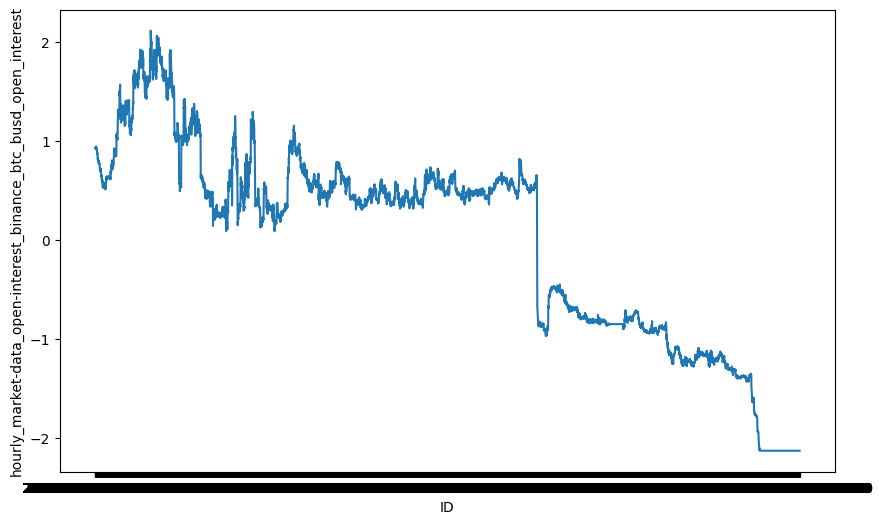

In [56]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[0])
plt.show()

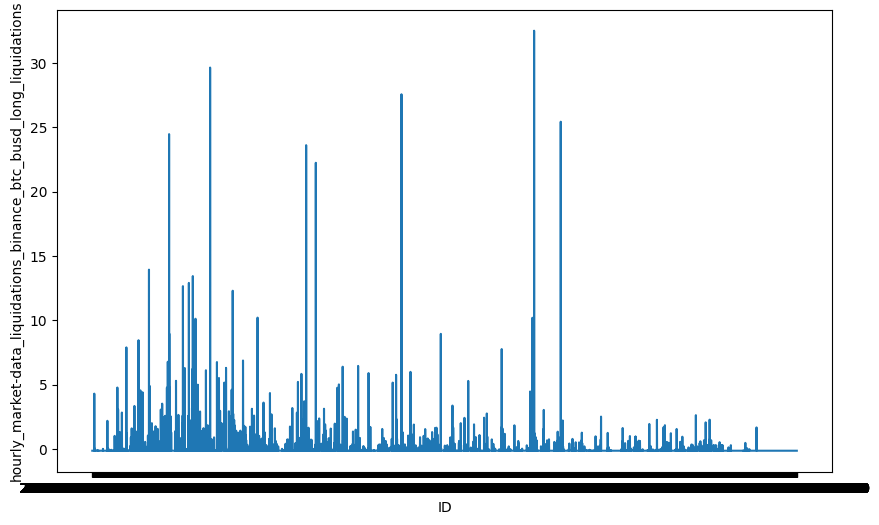

In [57]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[1])
plt.show()

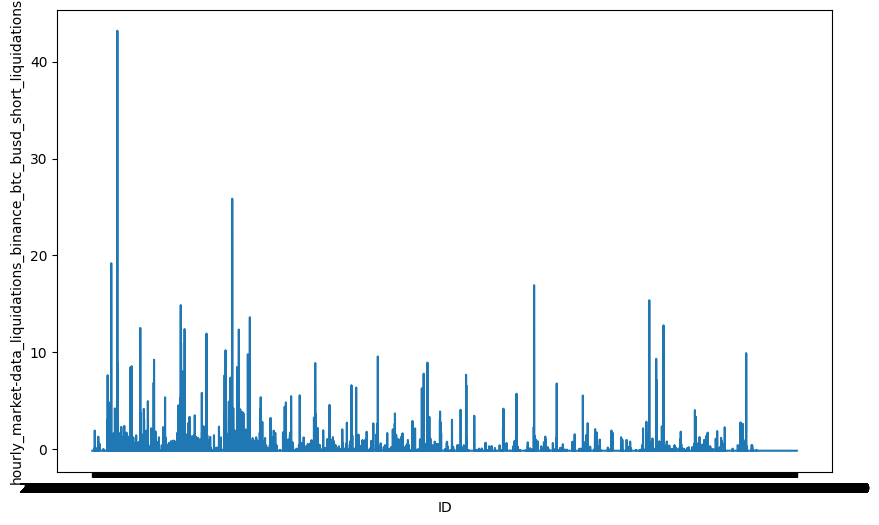

In [58]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[2])
plt.show()

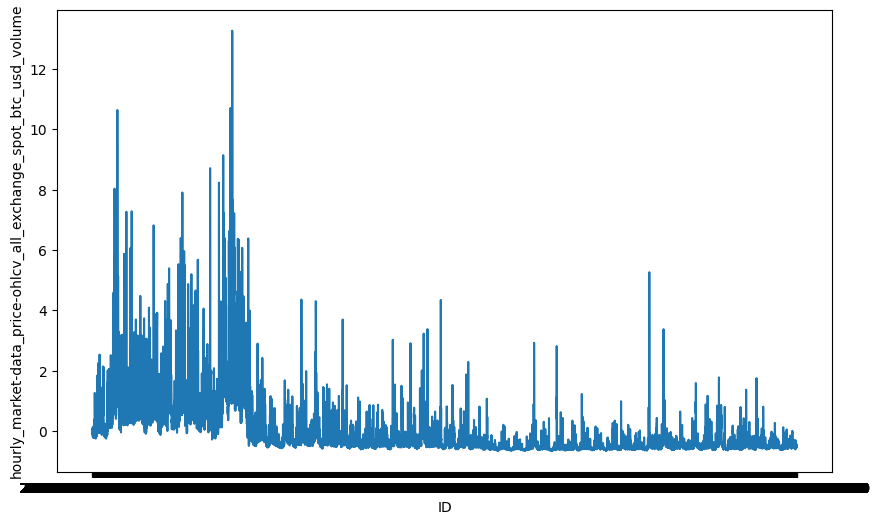

In [59]:
plt.figure(figsize=(10,6))
sns.lineplot(data=std_train_df, x='ID', y = columns_with_all_missing[3])
plt.show()